<hr style="border-width:2px"></hr>

# Comparing observational data with GeoClaw output
<hr style="border-width:2px"></hr>


This notebook post-processes the observational data found in the paper

M. Arcos and R. J. LeVeque, "Validating Velocities in the GeoClaw Tsunami Model using Observations Near Hawaii from the 2011 Tohoku Tsunami", Pure and Applied Geophysics, 2015. (2011).  http://dx.doi.org/10.1007/s00024-014-0980-y

This notebook has the following requirements : 


* Data from the above paper should be download from [this archive](http://doi.org/10.5281/zenodo.12185).   Any Python routines required from the archive have been duplicated here, so only the gauge data will be required from the archive. 

* To create plots comparing data with GeoClaw output, the GeoClaw Tohoku example should be run with velocity gauge 1123 and tide gauge 5680.  

* The [https://pypi.org/project/pandas/](Pandas) module is required to post-process archive data from the archive. 


In [1]:
%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
import os
import pandas

In [3]:
# Observational data downloaded from http://doi.org/10.5281/zenodo.12185
obs_dir = os.path.join('rjleveque-tohoku2011-paper2-096e44c')

# Directory containing gauge files gauge01123.txt and gauge05680.txt from GeoClaw
# To get a good comparison with observational data, the GeoClaw example should be 
# run with amr_level_max=6.  This takes 90 minutes to run. 
geoclaw_outdir = '_output'

### Earthquake data

The earthquake time is localized in UTC time coordinates.  We convert to Pacific/Honolulu so that it can be subtracted from times provided in gauge files.  

In [4]:
tquake = pandas.Timestamp('05:46:24 UTC on March 11, 2011',tz='Pacific/Honolulu')

### Routines for post-processing data 

The following routines are applied to rows Pandas data frames below. 

In [5]:
# Add column for time since quake (entry type pandas.Timedelta)
def time_since_quake(row):
    return row['date_time'] - tquake

# Add column for hours since quake (entry type : float64)
def hours_since_quake(row):
    return row['time_since_quake'].value/1e9/3600.

# Use this to construct velocities from speed and directions.
def set_velocity(row):
    s = row['Speed']
    theta = row['Dir']
    u = s * cos((90.-theta)*pi/180.)
    v = s * sin((90.-theta)*pi/180.)
    return [u,v]

# Compute final average
def average_vel(row,n):
    return [row['u']/n, row['v']/n]

## Create depth averaged data from velocity gauges 

Read depth data from depth files in `Observations\HAI*` directories and average the velocity data from these files to get single depth averaged u and v-velocities.  These depth-averaged velocities, along with date/time data and time since earthquake will be stored as columns in a Pandas DataFrame.   Data frames for each depth location will be stored as entries in a dictionary `gauges_avg`.  Directory keys are directory names containing depth files.  

The depth-averaged velocities are then detided and results are stored in text files. 

In [6]:
# Set columns to use for depth DataFrame
cols = ['DATE', 'TIME','Speed', 'Dir']

# Data provided from velocity gauges is localized in Pacific/Honolulu time zone.
def date_time(row):
    ts = row['TIME']
    nt = row['DATE'].replace(hour=ts.hour,minute=ts.minute,second=ts.second)
    return nt.tz_localize('Pacific/Honolulu')

# Create list of directories containing depth files
dlist = os.listdir(os.path.join(obs_dir, 'Observations'))
depth_dirs = []
for d in dlist:
    p = os.path.join(obs_dir,'Observations',d)
    if (os.path.isdir(p)):
        depth_dirs.append(d)

# Store data frames for each location here
gauges_avg = {}
for gdir in depth_dirs:
    print("Reading data in directory {:s}".format(gdir))
        
    # Read in depth file names
    depth_filenames = glob.glob(os.path.join(obs_dir,'Observations',gdir,\
                                'depth_*m.txt'))

    # ---------------------------------------------------------------------    
    # Read first depth file to get time and date info.  This assumes all depth 
    # files use the same time values (?)
    f0 = depth_filenames[0]
    df_dates = pandas.read_csv(f0,parse_dates=['DATE','TIME'], \
                               sep='\s+', \
                               names=cols,comment='#')

    # Combine date and time columns to get correct localize date/time stamp
    df_dates['date_time'] = df_dates.apply(date_time,axis=1)
    
    # Subtract time of initial quake to get a 'Timedelta'. 
    df_dates['time_since_quake'] = df_dates.apply(time_since_quake,axis=1)
    
    # Convert time delta to numerical value
    df_dates['hours_since_quake'] = df_dates.apply(hours_since_quake,axis=1)
    
    if gdir == "HAI1123_Kahului_harbor":
        # Correction mentioned in detide.py
        #    if gaugeno==1123:
        #        t2 = t2 - 1.   # correct error in NGDC data for this gauge
        df_dates['hours_since_quake'] -= 1       

    # ---------------------------------------------------------------------    
    # Create new DataFrame using only date/time info created above
    df_dates = df_dates.drop(['DATE','TIME','Speed','Dir'],axis=1)
    gf_avg = pandas.DataFrame(df_dates)

    # Add velocity columns and initialize velocities to zero.
    gf_avg[['u','v']] = gf_avg.apply(lambda row : [0,0],axis=1,result_type='expand')

    # ---------------------------------------------------------------------
    # Read all files and accumulate velocity averages.
    for f in depth_filenames:
        # print('Reading {:s}'.format(f))
        df = pandas.read_csv(f, parse_dates=['DATE','TIME'], \
                              sep='\s+',names=cols, \
                              comment='#')    
        
        # Compute velocity (u,v) from speed and direction stored in depth file
        df[['u','v']] = df.apply(set_velocity,axis=1,result_type='expand')
    
        # Accumulate velocities to be averaged. 
        gf_avg['u'] += df['u']
        gf_avg['v'] += df['v']

    # Average velocities
    n = len(depth_filenames)   
    gf_avg[['u','v']] = gf_avg.apply(average_vel, axis=1, result_type='expand', args=(n,))
    
    # Store data frame in a dictionary
    gauges_avg[gdir] = gf_avg

Reading data in directory HAI1123_Kahului_harbor
Reading data in directory HAI1116_Kalohi_Channel
Reading data in directory HAI1122_Maalaea_bay
Reading data in directory HAI1119_Auau_channel
Reading data in directory HAI1126_Hilo
Reading data in directory HAI1118_Hawea_point
Reading data in directory HAI1125_Hilo
Reading data in directory HAI1107_Hon_Harbor
Reading data in directory HAI1121_Alalakeiki_channel
Reading data in directory HAI1120_Lahaina


### Display resulting data frame containing averaged values
Extract the data frame from dictionary, and display results of averaged velocities.   

In [7]:
gauges_avg['HAI1123_Kahului_harbor']

,date_time,time_since_quake,hours_since_quake,u,v
0,2011-03-10 00:00:00-10:00,-1 days +04:13:36,-20.773333,-2.235401,-2.454118
1,2011-03-10 00:06:00-10:00,-1 days +04:19:36,-20.673333,-0.679134,-0.261690
2,2011-03-10 00:12:00-10:00,-1 days +04:25:36,-20.573333,-1.793350,-2.576127
3,2011-03-10 00:18:00-10:00,-1 days +04:31:36,-20.473333,-0.489741,-1.491649
4,2011-03-10 00:24:00-10:00,-1 days +04:37:36,-20.373333,-0.145940,-0.897632
...,...,...,...,...,...
475,2011-03-11 23:30:00-10:00,1 days 03:43:36,26.726667,-77.890341,-63.913127
476,2011-03-11 23:36:00-10:00,1 days 03:49:36,26.826667,2.680700,9.458981
477,2011-03-11 23:42:00-10:00,1 days 03:55:36,26.926667,38.219423,-18.168287
478,2011-03-11 23:48:00-10:00,1 days 04:01:36,27.026667,-37.988078,-51.993755


## Detide average velocity data using a best-fit polynomial
This subroutine was taking from `TG_DART_tools.py` in archive data. 

In [8]:
def fit_tide_poly(t,eta,degree):
    """
    Fit a polynomial of the specified degree to data 
    Returns the coefficents c of c[0] + c[1]*t + ...
    and the polynomial fit eta_fit.
    """
    from numpy.linalg import lstsq, svd
    # from pylab import find
    

    if numpy.any(numpy.isnan(eta)):
        eta2 = numpy.where(numpy.isnan(eta), 1e50, eta)
        # j_nonan = find(eta2 < 1e40)
        # t_nonan = t[j_nonan]
        # eta_nonan = eta[j_nonan]
        t_nonan = t[eta2 < 1e40]
        eta_nonan = eta[eta2 < 1e40]
        print("Ignoring %i NaN values" % (len(eta)-len(eta_nonan)))
    else:
        t_nonan = t
        eta_nonan = eta

    # Scale data so matrix better conditioned:

    scale_factor = abs(t_nonan).max()
    t_nonan = t_nonan/scale_factor
    t = t/scale_factor

    # Use Newton polynomial basis using these points:
    tpts = numpy.linspace(t_nonan.min(),t_nonan.max(),degree+1)
    
    # Form A matrix for least squares fit 
    A = numpy.ones((len(t_nonan),degree+1))
    for j in range(1,degree+1):
        A[:,j] = A[:,j-1] * (t_nonan - tpts[j])
    ncols = A.shape[1]
        
    # Perform least squares fit:
    c = lstsq(A,eta_nonan)[0]
    
    if numpy.any(numpy.isnan(eta)):
        # Reconstruct A using all times for calculating predicted:
        A = numpy.ones((len(t),degree+1))
        for j in range(1,degree+1):
            A[:,j] = A[:,j-1] * (t - tpts[j])

    eta_fit = numpy.dot(A,c)
    
    return eta_fit

Loop over all data frames storing averaged velocities and detide the velocities. 

In [9]:
for fname in gauges_avg.keys():
    gf_avg = gauges_avg[fname]
    thours = gf_avg['hours_since_quake']
    
    u = gf_avg['u'] 
    v = gf_avg['v'] 

    degree = 15
    u2 = fit_tide_poly(thours,u,degree)
    v2 = fit_tide_poly(thours,v,degree)

    # These values are essentially what is in "Observations/HAIXXXX/detided_poly.txt" 
    gf_avg['u_detided'] = gf_avg['u'] - u2
    gf_avg['v_detided'] = gf_avg['v'] - v2

    # Save detided velocities.  These can be compared directly with gauge results from 
    # GeoClaw.  Time is stored in hours, not seconds, so GeoClaw gauge times
    # have to be scaled. 
    cols = ['hours_since_quake', 'u_detided', 'v_detided']
    dname = '{:s}_detided.txt'.format(fname)
    print("Writing detide file {:s}".format(dname))
    gf_avg.to_csv(dname, columns = cols, 
                  sep='\t', \
                  header=False, \
                  index=False)

Writing detide file HAI1123_Kahului_harbor_detided.txt
Writing detide file HAI1116_Kalohi_Channel_detided.txt
Writing detide file HAI1122_Maalaea_bay_detided.txt
Writing detide file HAI1119_Auau_channel_detided.txt
Writing detide file HAI1126_Hilo_detided.txt
Writing detide file HAI1118_Hawea_point_detided.txt
Writing detide file HAI1125_Hilo_detided.txt
Writing detide file HAI1107_Hon_Harbor_detided.txt
Writing detide file HAI1121_Alalakeiki_channel_detided.txt
Writing detide file HAI1120_Lahaina_detided.txt


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


## Compare with detide_poly.txt files
The files `detide_poly.txt` in `Observations/HAI1123_Kahului_harbor` has detided data used in the Arcos and LeVeque paper.  The first few lines in this file are : 
        
        0.8266666667        -1.2291699317        -0.5807611893
        0.9266666667        -4.5312793719        -2.2852610736
        1.0266666667        -3.2835789096        -0.8140147343
        1.1266666667        -1.4856985873        -0.0352514633
        1.2266666667        -3.3774148624        -1.8623566264

We can compare these values with values in our DataFrame above.  The values are close, but don't match exactly - not sure why.   The solution is quite sensitive to degree of the polynomial used, but less sensitive to the time interval over which to fit the polynomial function. 

In [10]:
gf = gauges_avg['HAI1123_Kahului_harbor'][['hours_since_quake','u_detided','v_detided']]
t = gf['hours_since_quake']
gf[0.82 < t][0:5]

,hours_since_quake,u_detided,v_detided
216,0.826667,-1.252546,-0.572508
217,0.926667,-4.556000,-2.276234
218,1.026667,-3.309528,-0.804259
219,1.126667,-1.512753,-0.024816
220,1.226667,-3.405450,-1.851293


## Plot results at gauge HAI1123 and compare with GeoClaw

<IPython.core.display.Javascript object>


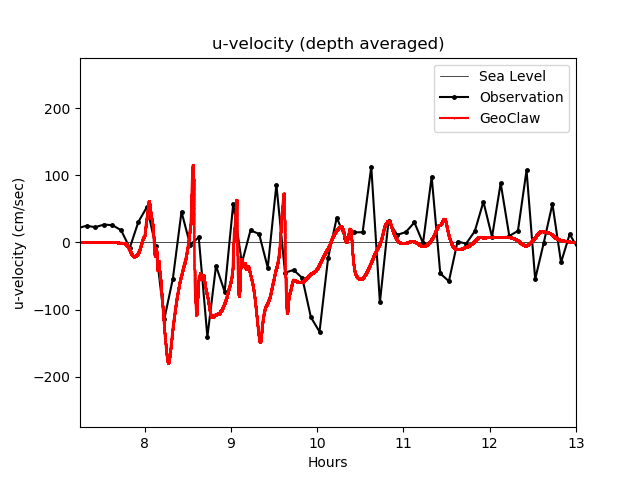

In [11]:
figure(1)
clf()

gf_avg = gauges_avg['HAI1123_Kahului_harbor']
thours = gf_avg['hours_since_quake']

# ------------------------------------------
# Plot reference sea level
plot(thours,0*thours,'k-',linewidth=0.5, label='Sea Level')

# ------------------------------------------
# Plot u-velocity data from observations
u = gf_avg['u_detided']
plot(thours,u,'k.-',markersize=5,label='Observation')

# ------------------------------------------
# Plot u-velocity gauge data from GeoClaw
f = os.path.join(geoclaw_outdir,'gauge01123.txt')
cols = ['level','t','q[1]','q[2]','q[3]','eta','aux']
df_gauge = df_dates = pandas.read_csv(f, sep='\s+', comment='#', names=cols)

tshift = 10*60   # Shift by 10 minutes (mentioned in tohoku paper)
tg = (df_gauge['t'] + tshift)/3600 
hg = df_gauge['q[1]']
ug = 100*df_gauge['q[2]']/hg    # Convert to cm/sec
vg = 100*df_gauge['q[3]']/hg    # Convert to cm/sec

plot(tg,ug,'r.-',markersize=1, label='GeoClaw')

# ------------------------------------------
# Fix up axes, add axes labels, title, etc. 
xlabel('Hours')
ylabel('u-velocity (cm/sec)')
title('u-velocity (depth averaged)')

yticks([-200, -100, 0, 100, 200])
ylim([-275,275])
xlim([7.25,13])
legend()
show()

<IPython.core.display.Javascript object>


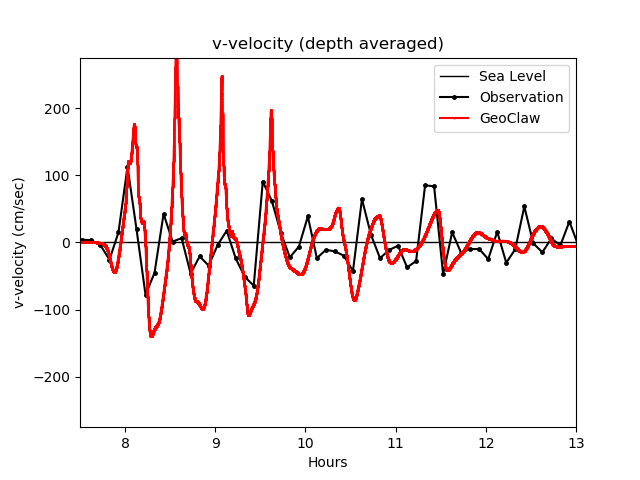

In [21]:
figure(2)
clf()

# ------------------------------------------
# Plot v-velocity data from observations
gf_avg = gauges_avg['HAI1123_Kahului_harbor']

thours = gf_avg['hours_since_quake']
v = gf_avg['v_detided']

# Plot sea-level
plot(thours,0*thours,'k-',linewidth=1,label='Sea Level')

# Plot observavational data
plot(thours,v,'k.-',markersize=5,label='Observation')

# ------------------------------------------
# Plot v-velocity gauge from GeoClaw
plot(tg,vg,'r.-',markersize=1, label='GeoClaw')

# ------------------------------------------
# Fix axes limits, add title, axes labels etc
xlabel('Hours')
ylabel('v-velocity (cm/sec)')
title('v-velocity (depth averaged)')

yticks([-200, -100, 0, 100, 200])
ylim([-275,275])
xlim([7.5,13])
legend()
show()

<hr style="border-width:2px; border-color:black"></hr>

# Read tide gauges and plot surface height

In the following, tide gauge data files are read and data used to compare surface elevations with GeoClaw results. 

Python scripts in archive refer to files `TG_XXXX_raw.csv` in directory `Observations/TideGauges`.  However, the only files that were found are

    1615680__2011-03-11_to_2011-03-13.csv
    1617760__2011-03-11_to_2011-03-13.csv

These are loaded below, and surface height data is compared with results from GeoClaw

In [14]:
# Tide gauge data is localized in UTC coordinates and then converted.
def date_time_tides(row):
    ts = row['TIME']
    nt = row['DATE'].replace(hour=ts.hour,minute=ts.minute,second=ts.second)
    return nt.tz_localize('UTC').tz_convert('Pacific/Honolulu')

tg_files = []
tg_files.append('1615680__2011-03-11_to_2011-03-13.csv')
tg_files.append('1617760__2011-03-11_to_2011-03-13.csv')

# Store tide gauge data in a dictionary. 
tide_gauges = {}
for k in range(2):
    csv_file = os.path.join(obs_dir,'TideGauges',tg_files[k])
    print('Reading file {:s}'.format(csv_file.split('/')[-1]))
    gf = pandas.read_csv(csv_file,parse_dates=['DATE','TIME'])

    # ---------------------------------------------------------------------
    # Add column with correct date and time (entry type : pandas.Timestamp)
    gf['date_time'] = gf.apply(date_time_tides,axis=1)

    # ---------------------------------------------------------------------
    # Add column for time since quake (entry type pandas.Timedelta)
    gf['time_since_quake'] = gf.apply(time_since_quake,axis=1)

    # ---------------------------------------------------------------------
    # Add column for hours since quake (entry type : float64)
    gf['hours_since_quake'] = gf.apply(hours_since_quake,axis=1)

    # Clean up values : Set '-' to NaN;  convert numeric types to float
    gf = gf.replace('-',nan)
    cols = ['1MIN', '6MIN', 'ALTERNATE', 'RESIDUAL', 'PREDICTED']
    convert = dict.fromkeys(cols, float)
    gf = gf.astype(convert)
    
    key = tg_files[k].split('__')[0]
    tide_gauges[key] = gf

Reading file 1615680__2011-03-11_to_2011-03-13.csv
Reading file 1617760__2011-03-11_to_2011-03-13.csv


## Display the tide gauge data

Display tide gauge data for a single tide gauge.  We drop the `DATE` and `TIME` columns for display purposes.  

In [15]:
tide_gauges['1615680'].drop(['DATE','TIME'],axis=1)

,1MIN,6MIN,ALTERNATE,PREDICTED,RESIDUAL,date_time,time_since_quake,hours_since_quake
0,0.44,NaN,NaN,NaN,NaN,2011-03-10 19:31:00-10:00,-1 days +23:44:36,-0.256667
1,0.44,NaN,NaN,NaN,NaN,2011-03-10 19:32:00-10:00,-1 days +23:45:36,-0.240000
2,0.43,NaN,NaN,NaN,NaN,2011-03-10 19:33:00-10:00,-1 days +23:46:36,-0.223333
3,0.44,NaN,NaN,NaN,NaN,2011-03-10 19:34:00-10:00,-1 days +23:47:36,-0.206667
4,0.44,NaN,NaN,NaN,NaN,2011-03-10 19:35:00-10:00,-1 days +23:48:36,-0.190000
...,...,...,...,...,...,...,...,...
2876,0.05,NaN,NaN,0.42,-0.37,2011-03-12 19:27:00-10:00,1 days 23:40:36,47.676667
2877,-0.02,NaN,NaN,0.43,-0.45,2011-03-12 19:28:00-10:00,1 days 23:41:36,47.693333
2878,-0.05,NaN,NaN,0.43,-0.48,2011-03-12 19:29:00-10:00,1 days 23:42:36,47.710000
2879,-0.07,-0.06,-0.07,0.43,-0.50,2011-03-12 19:30:00-10:00,1 days 23:43:36,47.726667


## Detide data using harmonic fit

Harmonic fit routine taken from TG_DART_tools.py.  Only minor change was to remove `find` function.  It seems this no longer available in pylab.

In [16]:
def fit_tide_harmonic(t, eta, periods, t0=0, svd_tol=0.01):
    from numpy.linalg import lstsq, svd, norm
    #from pylab import find
    
    if numpy.any(numpy.isnan(eta)):
        eta2 = numpy.where(numpy.isnan(eta), 1e50, eta)
        # j_nonan = find(eta2 < 1e40)
        # t_nonan = t[j_nonan]
        # eta_nonan = eta[j_nonan]
        t_nonan = t[eta2 < 1e40]
        eta_nonan = eta[eta2 < 1e40]
    else:
        t_nonan = t
        eta_nonan = eta

    A = numpy.ones(t_nonan.shape)
    names = periods.keys()
    for k in names:
        s1 = numpy.sin(2*numpy.pi*t_nonan/periods[k])
        c1 = numpy.cos(2*numpy.pi*t_nonan/periods[k])
        A = numpy.vstack([A,s1,c1])
    A = A.T
    ncols = A.shape[1]
    
    # c,res,rank,s = lstsq(A,eta)  ## Does not work well!
    # Using full least squares solution gives very large coefficients
    # Instead use SVD based pseudo-inverse throwing away singular
    # values below the specified tolerance:

    U,S,V = svd(A, full_matrices=False)
    #print "Singular values: ",S
    
    c = numpy.zeros(ncols)
    num_sv = 0
    for k in range(ncols):
        if S[k]/S[0] > svd_tol:
            c = c + (numpy.dot(U[:,k],eta_nonan) / S[k]) * V[k,:]
            num_sv += 1
    print("Inverting using %s singular values out of %s" % (num_sv, ncols))
    
    c_sin = c[1::2]
    c_cos = c[2::2]
    c_cos = numpy.where(abs(c_cos)<1e-10, 1e-10, c_cos)
    phi = -numpy.arctan(c_sin / c_cos) * 180./numpy.pi
    phi = numpy.where(c_cos < 0., phi+180, phi)
    

    # Determine offset, amplitude, phase so that fit has the form
    #  eta_fit = offset + sum_k amplitude[k] * cos(2*pi*(t - t0) + phase[k])
    # where the sum is over all harmonic constituents in periods.keys()

    offset = c[0]  # constant term in fit
    phase = {}
    amplitude = {}
    for i,name in enumerate(names):
        amplitude[name] = numpy.sqrt(c_sin[i]**2 + c_cos[i]**2)
        phase[name] = phi[i] + 360.*t0/periods[name]

    #print "c: ",c
    #print "c_cos: ",c_cos
    #print "c_sin: ",c_sin
    #print "+++ offset, amplitude, phase: ",offset, amplitude, phase
        
    if numpy.any(numpy.isnan(eta)):
        # Reconstruct A using all times for calculating predicted:
        A = numpy.ones(t.shape)
        for k in names:
            s1 = numpy.sin(2*numpy.pi*t/periods[k])
            c1 = numpy.cos(2*numpy.pi*t/periods[k])
            A = numpy.vstack([A,s1,c1])
        A = A.T

    eta_fit = numpy.dot(A,c)

    # residual = eta - eta_fit
    # print "Norm of residual: ",norm(residual,2)  # might return NaN
    # print "Norm of amplitudes: ",norm(c[1:],2)
    
    return eta_fit, amplitude, phase, offset

def get_periods():
    """
    Returns dictionary of tidal harmonic constituent periods (in hours).
    """
    
    periods = { \
        'K1': 23.9344697,
        'O1': 25.8193417,
        'M2': 12.4206012,
        'S2': 12.0000000,
        'M3': 08.2804008,
        'M4': 06.2103006,
        '2MK5': 04.9308802,
        'M6': 04.1402004,
        '3MK7': 03.10515030,
        'M8': 03.1051503,
        'N2': 12.6583482,
        'Q1': 26.8683567,
        'MK3': 08.1771399,
        'S4': 06.0000000,
        'MN4': 06.2691739,
        'NU2': 12.6260044,
        'S6': 04.0000000,
        'MU2': 12.8717576,
        '2N2': 12.9053745,
        'OO1': 22.3060742,
        'LAM2': 12.2217742,
        'S1': 24.0000000,
        'M1': 24.8332484,
        'J1': 23.0984768,
        'MM': 661.3092049,
        'SSA': 4382.9052087,
        'SA': 8765.8210896,
        'MSF': 354.3670522,
        'MF': 327.8589689,
        'RHO': 26.7230533,
        'T2': 12.0164492,
        'R2': 11.9835958,
        '2Q1': 28.0062225,
        'P1': 24.0658902,
        '2SM2': 11.6069516,
        'L2': 12.1916202,
        '2MK3': 08.3863030,
        'K2': 11.9672348,
        'MS4': 06.1033393,
        }
    return periods

periods = get_periods()
constituents_hawaii = ['J1','K1','K2','M2','N2','O1','P1','Q1','S2','SA']
periods_hawaii = {k:periods[k] for k in constituents_hawaii}

## Detide surface height using harmonic fit

In [17]:
p = periods_hawaii

for fname in tide_gauges.keys():
    gf_tide = tide_gauges[fname]

    thours = gf_tide['hours_since_quake']
    eta = gf_tide['1MIN']

    eta_fit, eta_offset, eta_amplitude, eta_phase= \
                        fit_tide_harmonic(thours, eta, periods=p, t0=0, svd_tol=1e-5)

    # Store detided data in DataFrame
    gf_tide['eta_detided'] = eta - eta_fit

Inverting using 14 singular values out of 21
Inverting using 14 singular values out of 21


## Plot surface height data

Plot the surface height data from gauge 1614680 and compare to GeoClaw results. 

<IPython.core.display.Javascript object>


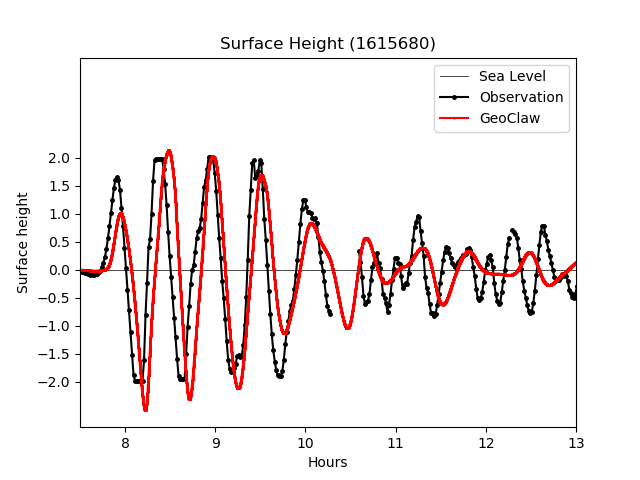

In [20]:
figure(3)
clf()

gf = tide_gauges['1615680']

thours = gf['hours_since_quake']

# Plot sea level
plot(thours,0*thours,'k-',label='Sea Level', linewidth=0.5)

# Plot data from observations
plot(thours,gf['eta_detided'],'k.-',markersize=5,label='Observation')

# Plot gauge data from GeoClaw
f = os.path.join(geoclaw_outdir,'gauge05680.txt')
cols = ['level','t','q[1]','q[2]','q[3]','eta','aux']
df_gauge = pandas.read_csv(f, sep='\s+', comment='#', names=cols)
tshift = 10*60
tg = (df_gauge['t'] + tshift)/3600  # Shift by 10 minutes
etag = df_gauge['eta']

plot(tg,etag,'r.-',markersize=1,label='GeoClaw')

xlabel('Hours')
ylabel('Surface height')
title('Surface Height (1615680)')

yticks(linspace(-2,2,9))
xlim([7.5,13])
legend()
show()